In [1]:
# Implementing age estimation and gender classification
# Dataset: UTKFace
# model: VGG16
# IMAGE_SIZE = 224

In [2]:
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
import os
import numpy as np
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

The labels of each face image is embedded in the file name, 
formated like [age]_[gender]_[race]_[date&time].jpg

[age] is an integer from 0 to 116, indicating the age
[gender] is either 0 (male) or 1 (female)
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [3]:
class UTKFaceDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        """
        Custom Dataset for UTKFace dataset
        
        Args:
            image_paths (list): List of image file paths
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.image_paths = image_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # 從檔名解析標籤
        image_path = self.image_paths[idx]
        filename = os.path.basename(image_path)
        
        # 解析檔名 [age]_[gender]_[race]_[date&time].jpg
        try:
            age, gender, race, _ = filename.split('_')
        except:
            age, gender, _ = filename.split('_') #有可能只有age和gender
        # 讀取圖片
        image = Image.open(image_path).convert('RGB')
         
        # 應用transform
        if self.transform:
            image = self.transform(image)
        
        # 轉換標籤為張量
        age = torch.tensor(int(age), dtype=torch.float32)
        gender = torch.tensor(int(gender), dtype=torch.long)
        
        return image, (age, gender)



In [4]:
class AgeGenderClassificationModel(nn.Module):
    def __init__(self, num_age_classes=117, num_gender_classes=2):
        """
        多任務學習模型，基於VGG16
        
        Args:
            num_age_classes (int): 年齡類別數量
            num_gender_classes (int): 性別類別數量
        """
        super(AgeGenderClassificationModel, self).__init__()
        
        # 載入預訓練VGG16模型
        vgg16 = torchvision.models.vgg16(weights='DEFAULT')
        
        # 凍結特徵提取層的參數
        for param in vgg16.features.parameters():
            param.requires_grad = False
        
        # 自定義分類器
        self.features = vgg16.features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Dropout()
        )
        
        # 多任務輸出層
        self.age_head = nn.Linear(1024, num_age_classes)
        self.gender_head = nn.Linear(1024, num_gender_classes)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        age_output = self.age_head(x)
        gender_output = self.gender_head(x)
        
        return age_output, gender_output

def train_and_validate(model, train_loader, val_loader, criterion_age, criterion_gender, optimizer, device, writer, num_epochs=10):
    """
    訓練和驗證模型，使用TensorBoard記錄
    
    Args:
        model (nn.Module): 深度學習模型
        train_loader (DataLoader): 訓練數據加載器
        val_loader (DataLoader): 驗證數據加載器
        criterion_age (nn.Module): 年齡損失函數
        criterion_gender (nn.Module): 性別損失函數
        optimizer (torch.optim): 優化器
        device (torch.device): 計算設備
        writer (SummaryWriter): TensorBoard寫入器
        num_epochs (int): 訓練輪數
    """
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_age_loss, train_gender_loss = 0.0, 0.0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            age_labels, gender_labels = labels[0].to(device), labels[1].to(device)
            
            optimizer.zero_grad()
            
            age_outputs, gender_outputs = model(images)
            
            age_loss = criterion_age(age_outputs, age_labels.long())
            gender_loss = criterion_gender(gender_outputs, gender_labels)
            
            total_loss = age_loss + gender_loss
            total_loss.backward()
            optimizer.step()
            
            train_age_loss += age_loss.item()
            train_gender_loss += gender_loss.item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}')
                print(f'Train Loss - Age: {age_loss.item():.4f}, Gender: {gender_loss.item():.4f}')
        
        # 驗證階段
        model.eval()
        val_age_loss, val_gender_loss = 0.0, 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                age_labels, gender_labels = labels[0].to(device), labels[1].to(device)
                
                age_outputs, gender_outputs = model(images)
                
                age_loss = criterion_age(age_outputs, age_labels.long())
                gender_loss = criterion_gender(gender_outputs, gender_labels)
                
                val_age_loss += age_loss.item()
                val_gender_loss += gender_loss.item()
        
        # 計算平均損失
        train_age_loss /= len(train_loader)
        train_gender_loss /= len(train_loader)
        val_age_loss /= len(val_loader)
        val_gender_loss /= len(val_loader)
        
        # TensorBoard記錄
        writer.add_scalar('Train/Age Loss', train_age_loss, epoch)
        writer.add_scalar('Train/Gender Loss', train_gender_loss, epoch)
        writer.add_scalar('Validation/Age Loss', val_age_loss, epoch)
        writer.add_scalar('Validation/Gender Loss', val_gender_loss, epoch)
        
        # 保存最佳模型
        if val_age_loss + val_gender_loss < best_val_loss:
            best_val_loss = val_age_loss + val_gender_loss
            torch.save(model.state_dict(), '05_AgeGender_model.pth')
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss - Age: {train_age_loss:.4f}, Gender: {train_gender_loss:.4f}')
        print(f'Val Loss - Age: {val_age_loss:.4f}, Gender: {val_gender_loss:.4f}')
    

In [5]:
# 定義數據轉換
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# 設置超參數和設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
learning_rate = 0.001

# 收集資料集路徑
dataset_path = 'data/UTKFace'
image_paths = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.jpg')]

# 分割訓練和驗證集
train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

# 創建數據加載器
train_dataset = UTKFaceDataset(train_paths, transform=transform)
val_dataset = UTKFaceDataset(val_paths, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# 初始化模型和損失函數
model = AgeGenderClassificationModel().to(device)
criterion_age = nn.CrossEntropyLoss()
criterion_gender = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# TensorBoard寫入器
writer = SummaryWriter('runs/age_gender_classification')

# 訓練和驗證
train_and_validate(model, train_loader, val_loader, 
                    criterion_age, criterion_gender, 
                    optimizer, device, writer)
writer.add_graph(model, torch.randn(1, 3, 224, 224).to(device))
# 關閉寫入器
writer.close()

Epoch 1/10, Batch 0/593
Train Loss - Age: 4.7554, Gender: 0.7075
Epoch 1/10, Batch 10/593
Train Loss - Age: 4.6276, Gender: 0.5835
Epoch 1/10, Batch 20/593
Train Loss - Age: 4.2625, Gender: 0.5261
Epoch 1/10, Batch 30/593
Train Loss - Age: 3.9181, Gender: 0.3618
Epoch 1/10, Batch 40/593
Train Loss - Age: 3.9408, Gender: 0.3894
Epoch 1/10, Batch 50/593
Train Loss - Age: 3.9511, Gender: 0.3855
Epoch 1/10, Batch 60/593
Train Loss - Age: 4.1540, Gender: 0.5429
Epoch 1/10, Batch 70/593
Train Loss - Age: 3.9622, Gender: 0.4305
Epoch 1/10, Batch 80/593
Train Loss - Age: 3.6610, Gender: 0.3347
Epoch 1/10, Batch 90/593
Train Loss - Age: 3.5808, Gender: 0.4856
Epoch 1/10, Batch 100/593
Train Loss - Age: 3.7894, Gender: 0.2547
Epoch 1/10, Batch 110/593
Train Loss - Age: 3.9240, Gender: 0.3781
Epoch 1/10, Batch 120/593
Train Loss - Age: 3.6652, Gender: 0.3629
Epoch 1/10, Batch 130/593
Train Loss - Age: 3.7716, Gender: 0.4269
Epoch 1/10, Batch 140/593
Train Loss - Age: 3.9270, Gender: 0.3209
Epoch 

Predicted Age: 26, Predicted Gender: Male


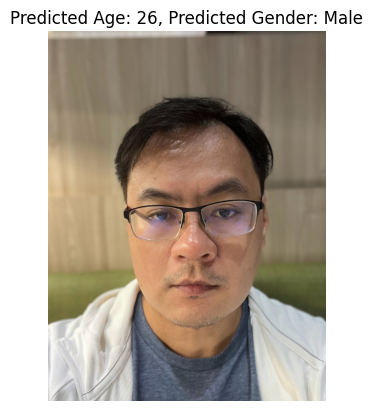

In [7]:
#載入 model，路徑是：05_AgeGender_model.pth
model = AgeGenderClassificationModel().to(device)
model.load_state_dict(torch.load('05_AgeGender_model.pth'))
model.eval()
#載入圖片：memememe.jpg
image = Image.open('memememe.jpg').convert('RGB')
#識別年齡與性別
with torch.no_grad():
    image = transform(image).unsqueeze(0).to(device)
    age_output, gender_output = model(image)
    age_pred = torch.argmax(age_output).item()
    gender_pred = torch.argmax(gender_output).item()
    print(f'Predicted Age: {age_pred}, Predicted Gender: {"Male" if gender_pred == 0 else "Female"}')
    
#呈現圖片，並顯示預測結果
plt.imshow(cv2.imread('memememe.jpg')[:,:,::-1])
plt.axis('off')
plt.title(f'Predicted Age: {age_pred}, Predicted Gender: {"Male" if gender_pred == 0 else "Female"}')
plt.show()  
